# **BERT-Based Embedding Generation and Similarity Computation**

## **Overview**
This script processes a large CSV file containing user-agent (UA) strings and device metadata. It leverages a pre-trained BERT model to generate embeddings for UA and metadata, computes their cosine similarity, and exports the results. By transforming textual data into high-dimensional vector representations, we can effectively analyze the relationships between different UA strings and metadata to identify patterns, detect anomalies, and enhance cybersecurity measures.

---

## **Understanding BERT-Based Embeddings**
### **1. What are Embeddings?**
Embeddings are dense vector representations of text that capture semantic relationships between words and phrases. In this script, we use BERT (Bidirectional Encoder Representations from Transformers) to generate embeddings for:
- **User-Agent (UA) strings:** Strings that describe the browser, operating system, and device type making a request.
- **Device Metadata:** Additional structured data fields such as OS, OS version, device vendor, model, and device type.

By mapping textual information to numerical vectors in a multi-dimensional space, BERT enables more sophisticated comparisons beyond simple string matching.

### **2. How Does BERT Generate Embeddings?**
- The BERT tokenizer processes the text and converts it into tokenized representations.
- These tokenized inputs are passed through a pre-trained BERT model (`bert-base-uncased`).
- The `[CLS]` token's embedding from the final hidden state is extracted as the representative vector for the input text.

### **3. Cosine Similarity Computation**
Cosine similarity measures the angle between two vectors in high-dimensional space. It is computed as:

where:
- **A and B** are the embedding vectors.
- **`A · B`** represents the dot product of the vectors.
- **`||A|| ||B||`** denotes their magnitudes.

A higher cosine similarity score (close to 1) indicates that the UA and metadata are more closely related, while a lower score (close to 0 or negative) suggests differences or anomalies.

---

## **How This Helps in Abnormality Detection**

### **1. Detecting Spoofed or Malicious Requests**
- Attackers often disguise their UA strings to mimic legitimate users.
- A **low similarity score** between the UA and metadata could indicate a mismatch, suggesting possible spoofing attempts.
- For example, if the UA claims "Windows 10" but metadata suggests a mobile device, it might be a fraudulent request.

### **2. Identifying Device Misconfigurations**
- Organizations maintaining security policies need accurate device metadata.
- Discrepancies between UA and metadata can highlight misconfigured devices that might pose security risks.

### **3. Preventing Automated Bot Attacks**
- Many bots use generic UA strings that do not align with their metadata.
- By analyzing similarity scores, we can flag requests that deviate significantly from normal user behavior.

### **4. Enhancing Fraud Detection in Web Traffic**
- Fraudulent activities often involve using manipulated user-agent strings.
- By creating a baseline of legitimate UA-metadata pairs, we can detect outliers that may indicate fraudulent transactions.

---

## **Key Steps in Implementation**

### **1. Load Pre-trained BERT Model and Tokenizer**
- The script initializes a `bert-base-uncased` model for tokenization and embedding generation.

### **2. Process Data in Chunks**
- Uses pandas `read_csv(..., chunksize=1000)` to handle large files efficiently.
- Reduces memory load by processing data in smaller portions.

### **3. Generate BERT Embeddings for UA and Metadata**
- Tokenizes UA and metadata fields.
- Extracts `[CLS]` token embeddings as vector representations.

### **4. Compute Cosine Similarity**
- Converts embeddings into PyTorch tensors.
- Uses `torch.nn.functional.cosine_similarity()` to compute similarity scores.
- Processes data in batches to optimize performance.

### **5. Export Results for Analysis**
- Saves similarity scores to a CSV file (`feature_9.csv`).
- Creates a processed dataset (`ua_analysis.csv`) with request timestamps, device identifiers, and similarity scores.

---

## **Conclusion**
This approach provides a robust method for analyzing UA strings and metadata using BERT embeddings. By computing cosine similarity scores, we can detect mismatches, enhance fraud prevention, and improve cybersecurity measures. Leveraging AI-driven anomaly detection allows organizations to proactively mitigate risks and ensure data integrity in web applications.


In [10]:
from transformers import BertTokenizer, BertModel
import torch
import pandas as pd
import gc
import numpy as np
import psutil  # To track system RAM usage

In [11]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [14]:
# Read the Excel file
df = pd.read_excel(
    "/content/CombinedCountryData_2.0-IPv4_Cleaned.xlsx",
    sheet_name="normalized_file123"
)

# Define chunk size
chunk_size = 1000  # Or any desired size

# Split the DataFrame into chunks
num_chunks = len(df) // chunk_size + 1
df_chunks = [df[i * chunk_size:(i + 1) * chunk_size] for i in range(num_chunks)]


# Debug: Check initial memory usage
def print_memory_usage(msg):
    print(f"\n[DEBUG] {msg}")
    print(f" - System RAM Usage: {psutil.virtual_memory().percent}%")
    if torch.cuda.is_available():
        print(f" - GPU Memory Allocated: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
        print(f" - GPU Memory Cached: {torch.cuda.memory_reserved() / 1e6:.2f} MB")

print_memory_usage("Before Processing")

def get_bert_embeddings(texts, model, tokenizer):
    # Tokenize the input texts
    inputs = tokenizer(
        texts, padding=True, truncation=True, return_tensors='pt', max_length=512
    )

    # Move inputs to GPU
    inputs = {key: val.to(device, non_blocking=True) for key, val in inputs.items()}

    # Get embeddings without computing gradients
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract embeddings and move them back to CPU
    embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    del inputs, outputs
    torch.cuda.empty_cache()
    gc.collect()

    return embeddings

all_ua_embeddings = []
all_metadata_embeddings = []

for i, chunk in enumerate(df_chunks):
    print(f"\n[DEBUG] Processing Chunk {i+1}...")

    # Combine metadata columns into a single string
    chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)

    chunk_index = chunk.index.tolist()

    print(f" - Generating UA embeddings for {len(chunk)} rows...")
    ua_embeddings = get_bert_embeddings(chunk['ua'].tolist(), model, tokenizer)

    print(f" - Generating Metadata embeddings for {len(chunk)} rows...")
    metadata_embeddings = get_bert_embeddings(chunk['metadata'].tolist(), model, tokenizer)

    # Debug: Ensure embeddings match row count
    assert len(ua_embeddings) == len(chunk), "[ERROR] UA Embeddings mismatch!"
    assert len(metadata_embeddings) == len(chunk), "[ERROR] Metadata Embeddings mismatch!"

    # Store embeddings with their corresponding indices
    all_ua_embeddings.append((chunk_index, ua_embeddings))
    all_metadata_embeddings.append((chunk_index, metadata_embeddings))

    # Explicit memory release
    del chunk, ua_embeddings, metadata_embeddings
    gc.collect()
    torch.cuda.empty_cache()

    print_memory_usage(f"After Processing Chunk {i+1}")

# Convert to a dictionary for easy lookup
ua_embeddings_dict = {idx: emb for chunk_index, emb in all_ua_embeddings for idx, emb in zip(chunk_index, emb)}
metadata_embeddings_dict = {idx: emb for chunk_index, emb in all_metadata_embeddings for idx, emb in zip(chunk_index, emb)}

# Read full dataframe again to merge embeddings
print("\n[DEBUG] Reading full CSV for merging...")
df_full = pd.read_excel(
    "/content/CombinedCountryData_2.0-IPv4_Cleaned.xlsx",
    sheet_name="normalized_file123"
)

# Map embeddings to the full dataframe
df_full['ua_embedding'] = df_full.index.map(ua_embeddings_dict)
df_full['metadata_embedding'] = df_full.index.map(metadata_embeddings_dict)

# Debug: Check if embeddings were correctly assigned
print(f"[DEBUG] Number of rows in df_full: {len(df_full)}")
print(f"[DEBUG] Number of non-null UA embeddings: {df_full['ua_embedding'].notnull().sum()}")
print(f"[DEBUG] Number of non-null Metadata embeddings: {df_full['metadata_embedding'].notnull().sum()}")

print_memory_usage("After Merging Embeddings")

# Now df_full contains embeddings correctly aligned to each row


[DEBUG] Before Processing
 - System RAM Usage: 28.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 1...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 1
 - System RAM Usage: 28.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 2...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 2
 - System RAM Usage: 28.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 3...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 3
 - System RAM Usage: 28.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 4...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 4
 - System RAM Usage: 28.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 5...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 5
 - System RAM Usage: 28.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 6...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 6
 - System RAM Usage: 28.6%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 7...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 7
 - System RAM Usage: 28.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 8...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 8
 - System RAM Usage: 28.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 9...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 9
 - System RAM Usage: 28.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 10...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 10
 - System RAM Usage: 28.0%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 11...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 11
 - System RAM Usage: 28.2%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 12...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 12
 - System RAM Usage: 28.2%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 13...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 13
 - System RAM Usage: 28.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 14...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 14
 - System RAM Usage: 28.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 15...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 15
 - System RAM Usage: 28.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 16...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 16
 - System RAM Usage: 28.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 17...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 17
 - System RAM Usage: 28.4%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 18...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 18
 - System RAM Usage: 28.4%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 19...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 19
 - System RAM Usage: 28.4%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 20...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 20
 - System RAM Usage: 28.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 21...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 21
 - System RAM Usage: 28.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 22...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 22
 - System RAM Usage: 28.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 23...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 23
 - System RAM Usage: 28.6%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 24...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 24
 - System RAM Usage: 28.7%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 25...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 25
 - System RAM Usage: 28.7%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 26...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 26
 - System RAM Usage: 28.7%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 27...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 27
 - System RAM Usage: 28.8%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 28...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 28
 - System RAM Usage: 28.8%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 29...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 29
 - System RAM Usage: 28.9%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 30...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 30
 - System RAM Usage: 28.9%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 31...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 31
 - System RAM Usage: 29.0%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 32...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 32
 - System RAM Usage: 29.1%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 33...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 33
 - System RAM Usage: 29.1%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 34...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 34
 - System RAM Usage: 29.1%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 35...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 35
 - System RAM Usage: 29.2%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 36...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 36
 - System RAM Usage: 29.2%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 37...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 37
 - System RAM Usage: 29.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 38...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 38
 - System RAM Usage: 29.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 39...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 39
 - System RAM Usage: 29.4%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 40...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 40
 - System RAM Usage: 29.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 41...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 41
 - System RAM Usage: 29.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 42...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 42
 - System RAM Usage: 29.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 43...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 43
 - System RAM Usage: 29.6%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 44...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 44
 - System RAM Usage: 29.6%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 45...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 45
 - System RAM Usage: 29.6%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 46...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 46
 - System RAM Usage: 29.7%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 47...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 47
 - System RAM Usage: 29.7%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 48...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 48
 - System RAM Usage: 29.8%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 49...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 49
 - System RAM Usage: 29.8%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 50...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 50
 - System RAM Usage: 29.8%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 51...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 51
 - System RAM Usage: 29.9%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 52...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 52
 - System RAM Usage: 30.0%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 53...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 53
 - System RAM Usage: 30.0%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 54...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 54
 - System RAM Usage: 30.0%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 55...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 55
 - System RAM Usage: 30.1%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 56...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 56
 - System RAM Usage: 30.1%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 57...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 57
 - System RAM Usage: 30.2%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 58...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 58
 - System RAM Usage: 30.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 59...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 59
 - System RAM Usage: 30.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 60...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 60
 - System RAM Usage: 30.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 61...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 61
 - System RAM Usage: 30.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 62...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 62
 - System RAM Usage: 30.4%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 63...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 63
 - System RAM Usage: 30.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 64...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 64
 - System RAM Usage: 30.6%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 65...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 65
 - System RAM Usage: 30.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 66...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 66
 - System RAM Usage: 30.6%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 67...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 67
 - System RAM Usage: 30.6%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 68...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 68
 - System RAM Usage: 30.7%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 69...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 69
 - System RAM Usage: 30.8%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 70...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 70
 - System RAM Usage: 30.8%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 71...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 71
 - System RAM Usage: 30.8%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 72...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 72
 - System RAM Usage: 30.9%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 73...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 73
 - System RAM Usage: 30.9%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 74...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 74
 - System RAM Usage: 31.1%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 75...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 75
 - System RAM Usage: 31.0%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 76...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 76
 - System RAM Usage: 31.1%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 77...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 77
 - System RAM Usage: 31.1%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 78...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 78
 - System RAM Usage: 31.2%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 79...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 79
 - System RAM Usage: 31.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 80...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 80
 - System RAM Usage: 31.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 81...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 81
 - System RAM Usage: 31.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 82...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 82
 - System RAM Usage: 31.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 83...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 83
 - System RAM Usage: 31.4%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 84...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 84
 - System RAM Usage: 31.4%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 85...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 85
 - System RAM Usage: 31.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 86...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 86
 - System RAM Usage: 31.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 87...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 87
 - System RAM Usage: 31.6%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 88...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 88
 - System RAM Usage: 31.6%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 89...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 89
 - System RAM Usage: 31.7%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 90...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 90
 - System RAM Usage: 31.7%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 91...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 91
 - System RAM Usage: 31.7%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 92...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 92
 - System RAM Usage: 31.8%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 93...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 93
 - System RAM Usage: 31.9%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 94...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 94
 - System RAM Usage: 31.9%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 95...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 95
 - System RAM Usage: 32.0%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 96...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 96
 - System RAM Usage: 32.0%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 97...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 97
 - System RAM Usage: 32.2%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 98...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 98
 - System RAM Usage: 32.2%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 99...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 99
 - System RAM Usage: 32.2%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 100...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 100
 - System RAM Usage: 32.2%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 101...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 101
 - System RAM Usage: 32.2%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 102...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 102
 - System RAM Usage: 32.2%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 103...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 103
 - System RAM Usage: 32.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 104...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 104
 - System RAM Usage: 32.3%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 105...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 105
 - System RAM Usage: 32.4%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 106...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 106
 - System RAM Usage: 32.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 107...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 107
 - System RAM Usage: 32.4%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 108...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 108
 - System RAM Usage: 32.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 109...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 109
 - System RAM Usage: 32.5%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 110...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 110
 - System RAM Usage: 32.6%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 111...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 111
 - System RAM Usage: 32.7%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 112...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 112
 - System RAM Usage: 32.7%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 113...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 113
 - System RAM Usage: 32.7%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 114...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 114
 - System RAM Usage: 32.8%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 115...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 115
 - System RAM Usage: 32.9%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 116...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 116
 - System RAM Usage: 32.9%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 117...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 117
 - System RAM Usage: 33.0%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 118...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 118
 - System RAM Usage: 33.0%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 119...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 119
 - System RAM Usage: 33.0%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 120...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 120
 - System RAM Usage: 33.1%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 121...
 - Generating UA embeddings for 1000 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 1000 rows...

[DEBUG] After Processing Chunk 121
 - System RAM Usage: 33.2%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Processing Chunk 122...
 - Generating UA embeddings for 585 rows...


<ipython-input-14-9832f32bc56b>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['metadata'] = chunk[['os', 'normalized_osv', 'device_vendor', 'device_model', 'deviceType']].fillna('').astype(str).agg(' '.join, axis=1)


 - Generating Metadata embeddings for 585 rows...

[DEBUG] After Processing Chunk 122
 - System RAM Usage: 33.1%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB

[DEBUG] Reading full CSV for merging...
[DEBUG] Number of rows in df_full: 121585
[DEBUG] Number of non-null UA embeddings: 121585
[DEBUG] Number of non-null Metadata embeddings: 121585

[DEBUG] After Merging Embeddings
 - System RAM Usage: 33.2%
 - GPU Memory Allocated: 1325.73 MB
 - GPU Memory Cached: 1438.65 MB


In [15]:
df_full.columns

Index(['reqTimeConverted', 'deviceIfa', 'os', 'osv', 'normalized_osv',
       'ipAddress', 'carrier', 'connectionType', 'device_vendor',
       'device_model', 'device_height', 'device_width', 'deviceType',
       'location_type', 'latitude', 'longitude', 'appBundle',
       'device_country_code', 'ua', 'ua_embedding', 'metadata_embedding'],
      dtype='object')

In [16]:
df_full.shape

(121585, 21)

In [17]:
# Set Device (Use GPU if Available)
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 500  # Process in batches of 250

similarity_scores = []

# Process Data in Batches
for i in range(0, len(df_full), batch_size):
    print(f"Processing batch {i // batch_size + 1}...")  # Debugging

    # Select batch
    batch_df = df_full.iloc[i:i + batch_size]

    # Convert to PyTorch Tensors and Move to GPU
    ua_embeddings = torch.tensor(np.stack(batch_df["ua_embedding"].to_numpy()), dtype=torch.float32).to(device)
    metadata_embeddings = torch.tensor(np.stack(batch_df["metadata_embedding"].to_numpy()), dtype=torch.float32).to(device)

    # Compute Cosine Similarity
    batch_similarity = torch.nn.functional.cosine_similarity(ua_embeddings, metadata_embeddings, dim=1)

    # Store results in list (Move to CPU)
    similarity_scores.extend(batch_similarity.cpu().numpy())

    # Free GPU memory
    del ua_embeddings, metadata_embeddings, batch_similarity
    torch.cuda.empty_cache()

# Add Similarity Scores to DataFrame
df_full["similarity_score"] = similarity_scores

print("Cosine Similarity Computed Successfully!")


Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...
Processing batch 5...
Processing batch 6...
Processing batch 7...
Processing batch 8...
Processing batch 9...
Processing batch 10...
Processing batch 11...
Processing batch 12...
Processing batch 13...
Processing batch 14...
Processing batch 15...
Processing batch 16...
Processing batch 17...
Processing batch 18...
Processing batch 19...
Processing batch 20...
Processing batch 21...
Processing batch 22...
Processing batch 23...
Processing batch 24...
Processing batch 25...
Processing batch 26...
Processing batch 27...
Processing batch 28...
Processing batch 29...
Processing batch 30...
Processing batch 31...
Processing batch 32...
Processing batch 33...
Processing batch 34...
Processing batch 35...
Processing batch 36...
Processing batch 37...
Processing batch 38...
Processing batch 39...
Processing batch 40...
Processing batch 41...
Processing batch 42...
Processing batch 43...
Processing batch 44.

In [18]:
df_full["similarity_score"].to_csv("feature_9.csv")

# Visualization and Insights

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

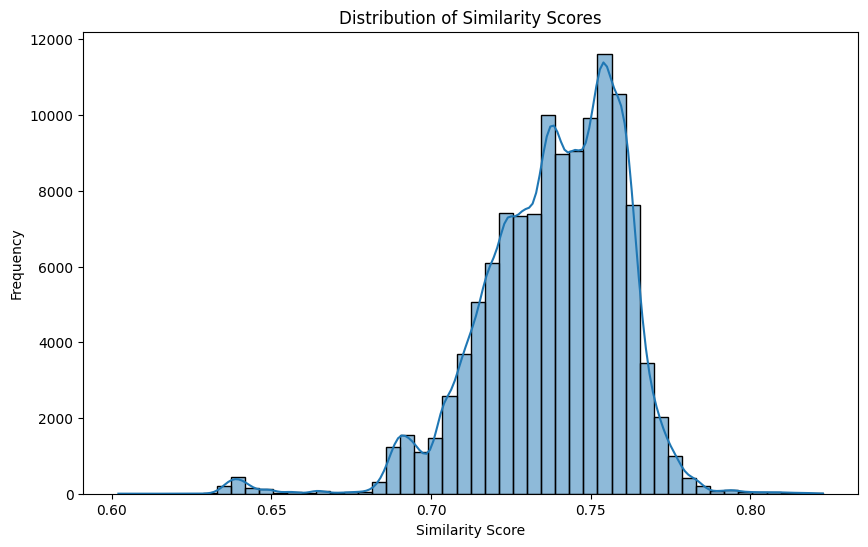

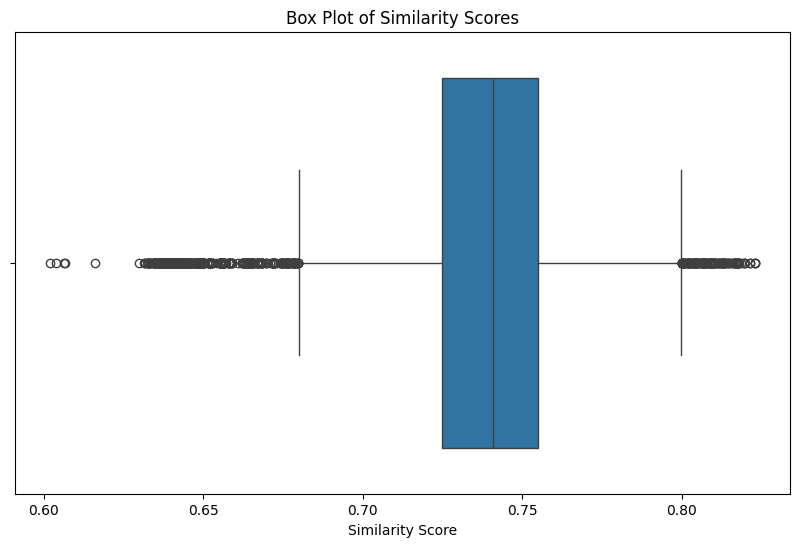

In [20]:
# 1. Distribution of Similarity Scores
plt.figure(figsize=(10, 6))
sns.histplot(df_full['similarity_score'], bins=50, kde=True)
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

# 2. Box Plot for Similarity Scores
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_full['similarity_score'])
plt.title('Box Plot of Similarity Scores')
plt.xlabel('Similarity Score')
plt.show()


## UA string similarity score Analysis

### **1. Distribution of Similarity Scores**  

#### **Observations**:  
- **Primary Peak**: Majority of scores cluster around **0.75** (frequency ~8,000).  
- **Secondary Peaks**: Smaller spikes at **0.70** and **0.80**.  
- **Low-Score Tail**: Non-trivial counts (~2,000) at **0.60–0.65**.  

#### **Abnormality Insights**:  
- **0.75 Peak**: Represents **normal traffic** where user-agent (UA) and device metadata (OS, model, etc.) align.  
- **Low Scores (0.60–0.65)**:  
  - Indicate **UA-metadata mismatches**, e.g.:  
    - Spoofed UAs (e.g., `Chrome` UA paired with `iOS` metadata).  
    - Malware/botnets using randomized UA strings to evade detection.  
  - Could signal **credential stuffing** (tools like Sentry MBA generate mismatched headers).  

---

### **2. Box Plot of Similarity Scores**  

#### **Observations**:  
- **Median**: ~0.75 (matches distribution peak).  
- **IQR**: 0.70–0.80 (interquartile range).  
- **Outliers**: Scores below **0.65** (beyond the lower whisker).  

#### **Abnormality Insights**:  
- **Outliers (<0.65)**:  
  - **Advanced Threats**: Likely **malicious automation** (e.g., headless browsers with mismatched metadata).  
- **Tight IQR**: Most legitimate traffic has consistent UA-metadata pairs.  

### **Summary**  
The data reveals **two distinct populations**:  
- **Legitimate Traffic**: Tightly clustered around 0.75 (UA-metadata consistency).  
- **Anomalous Traffic**: Low-score outliers (0.60–0.65) indicating **spoofing, bots, or credential-stuffing tools**.  